# Laboratory Exercise. Estimation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math

Company *Like2Call* offers hosting services for call centers. In order to better dimension the staff of operator, the company has collected a lot of data about the activity of the service during 5 consecutive labour days.

This data is stored in the following variables:

  * ${\bf t}$: An array containing the ordered timestamps of all calls received during 5 consecutive days, in minutes.
  * ${\bf d}$: An array containing the respective duration of each call in ${\bf t}$.
 
These variables can be found in file `dataset.npz`

In [2]:
# <SOL>
# ###############
# Data generation
# ###############

# #######################
# Generate starting times

# Generate s using the known prior
np.random.seed(0)
n_calls = 2000     # Total no. of calls in the whole period
minday = 24*60    # Total no. of minutes in a day
n_days = 5

# Day of each call, uniformly at randomm between 0 and n_days-1
day = np.random.randint(0, high=n_days, size=n_calls)

# Minutes unyformly at random
t_d_0 = np.random.uniform(minday, size=n_calls)
# Minutes from a beta distribution
t_d_1 = minday * np.random.beta(9, 4, size=n_calls)
# Minutes from a mixture of uniform and beta distributions
b = np.random.binomial(1, 0.1, size=n_calls)

t = day * minday + b * t_d_0 + (1-b) * t_d_1
t = np.sort(t)

# #######################
# Generate call durations
d = np.random.exponential(8, size=len(t))

data = {'t': t, 'd': d}
np.savez('dataset.npz', **data)
# </SOL>

datanew = np.load('dataset.npz')
t = datanew['t']
d = datanew['d']

### 1. Time between calls

 * [1.1] Plot the histogram of the timestamps

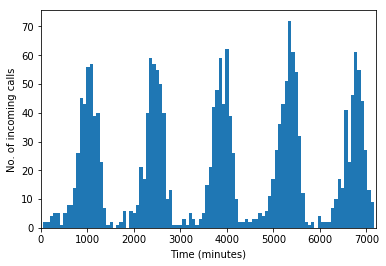

In [3]:
# Histograms of call times
# <SOL>
plt.hist(t, bins=100)
plt.xlabel('Time (minutes)')
plt.ylabel('No. of incoming calls')
plt.xlim([0, n_days*minday])
plt.show()
# </SOL>


 * [1.2] Generate an array `x_all` containing the succesive time beween calls, and plot the corresponding histogram.

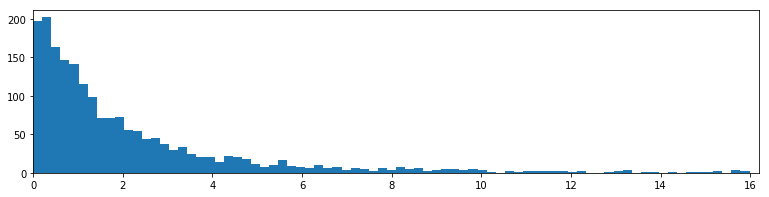

In [4]:
# <SOL>
x_all = np.diff(t)
plt.figure(figsize=(13,3))
plt.hist(x_all, bins=800)
plt.xlim([0, max(x_all)/10])
plt.show()
# </SOL>

### 2. Parameter estimation.

The company has decided to build a statistical model to characterize the activity in the hosted call centers. By looking at the histogram, it seems that the time between incoming calls may follow an exponential distribution

$$
p_{X|S}(x|s) = s \exp(−s x), \qquad x > 0
$$

where random variable $X$ represents the time before a new call arrives, and $S$ is the parameter of such distribution. Thus, we will use the dataset to estimate parameter $s$.

#### 2.1. Maximum likelihood

 * [2.1]. Obtain the maximum likelihood estimator or $S$ based on the observations in `x_all`, and save it in variable `sML`. You will need to compute two variables that will be used several times along this section:
     - $K$: The number of observations in `x_all`
     - $z = \sum_{k=0}^{K-1} x^{(k)}$, where $x^{(k)}$ are the components of `x_all`.

In [5]:
# <SOL>
z = np.sum(x_all)
K = len(x_all)
sML = K / z
# </SOL>

display(Math(r'\hat{s}_\text{ML} = ' + str(sML)))

<IPython.core.display.Math object>

 * [2.2]. Plot the log of the likelihood as a function of $s$ (in the appropriate range of $s$) and verify that the ML estimate reaches the maximum.

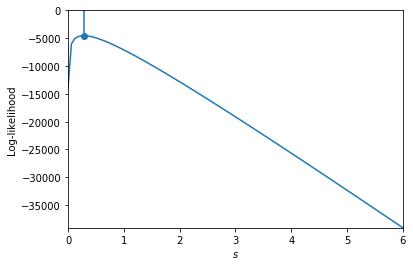

In [6]:
# <SOL>
s = np.linspace(0.001, 6, 101)

def Lp(s, z, K):
    return K*np.log(s) - s*z

Lmax = Lp(sML, z, K)
Ls = Lp(s, z, K)

plt.plot(s, Ls)
plt.stem([sML], [Lmax])
plt.xlim((s[0], s[-1]))
plt.ylim([np.min(Ls), 0])
plt.xlabel('$s$')
plt.ylabel('Log-likelihood')
plt.show()
# </SOL>

#### 2.2. Bayesian estimation

In order to apply Bayesian estimation methods, parameter $S$ is taken as a random variable with the following a priori model:

$$
p_S(s) = \exp(−s), \qquad s > 0.
$$

* [2.3.] Obtain the maximum a posteriori estimator of $S$ given $X$, and save it in variable `sMAP`.

In [7]:
# </SOL>
sMAP = K / (z + 1)
# </SOL>

display(Math(r'\hat{s}_\text{MAP} = ' + str(sMAP)))

<IPython.core.display.Math object>

 * [2.4]. Plot the posterior probability of parameter $S$ as a function of $s$ (in the appropriate range of $s$) and verify that the MAP estimate reaches the maximum.

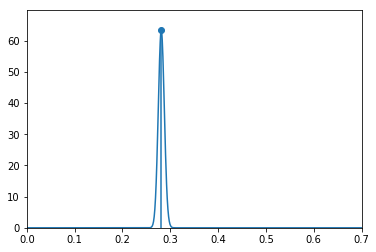

In [8]:
# <SOL>
def PP(s, z, K):
    logPP = K*np.log(s) + (K+1)*np.log(z+1) - s*(z+1) - np.sum(np.log(range(1, K+1)))
    return np.exp(logPP)

s = np.linspace(0.0001, 0.7, 1000)
plt.plot(s, PP(s, z, K))
plt.stem([sMAP], [PP(sMAP, z, K)])
plt.xlim((s[0], s[-1]))
plt.ylim((0, 1.1*PP(sMAP, z, K)))
plt.show()
# </SOL>

 * [2.5.] Obtain the minimum mean square error estimator of $S$ given $X$ and save it in variable `sMSE`.

In [9]:
# <SOL>
sMSE = (K + 1) / (z + 1)
# </SOL>

display(Math(r'\hat{s}_\text{MSE} = ' + str(sMSE)))

<IPython.core.display.Math object>

 * [2.6.] Note the MAP and the MSE estimates are very similar because the posterior distribution is approximately (although not exactly) symmetric. Also, the MSE estimate is only slightly different from the ML estimate, because we have a large dataset and the influence of the prior distribution decreases when we have much empirical evidence.
 
   However, the Bayesian approach provides not only an estimate but a posterior distribution, that describes how much we know about the true value of parameter $S$ after the data observation. The variance of this distribution describes how far the true value of $S$ could be from the posterior mean.
   
   (Incidentally, note that, since $\hat{s}_\text{MSE}$ is the posterior mean, the conditional MSE, which is given by,

   $$
   \mathbb{E}\left\{(S-\hat{s}_\text{MSE})^2| {\bf z}\right\}
   $$

   is equal to the variance of the posterior distribution).
   
   Compute the Minimum MSE for the given data, and save it in variable `mmse`

In [10]:
print("The minimum MSE is given by ")
# mmse = <FILL IN>
mmse = (K+1)/(z+1)**2

display(Math(r'\text{MSE} = \frac{K+1}{(z +1)^2} = ' + str(mmse) ))

The minimum MSE is given by 


<IPython.core.display.Math object>

 * [2.7.] [OPTIONAL] Compute the probability that the true parameter value is further than 2 standard deviations from the posterior mean.

In [11]:
# <SOL>

# </SOL>

### 3. An improved data model.

#### 3.1. Temporal dynamics

The analysis in Section 2 is grounded on the assumption that the time between incoming calls follows an exponential distribution. The histogram obtained in exercise [1.2] provides some experimental evidence in support of this assumption. 

However, the histogram computed in exercise [1.1.] also shows that the activity of the call center varies with the time of the day. Therefore, we can expect that the time between calls also depends in the time of the day.

* [3.1] Plot the time between calls, as a function of time.

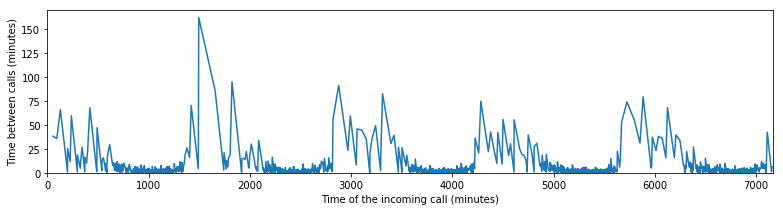

In [12]:
# <SOL>
plt.figure(figsize=(13,3))
plt.plot(t[:-1], x_all)  
plt.xlim([0, np.max(t)])
plt.ylim([0, 1.05*np.max(x_all)])
plt.xlabel('Time of the incoming call (minutes)')
plt.ylabel('Time between calls (minutes)')
plt.show()
# </SOL>


According to this, we can make a different model for each time of the day. To do so, we will keep the asumption that the time between incoming calls may follows an exponential distribution

$$
p_{X|S,}(x \mid s) = s \exp(−s x), \qquad x > 0
$$

but parameter $s$ can take a different value from hour to hour.

In order to compute the parameter estimates, we will need to split the data in 24 groups, one per hour, and compute parameters $z$ and $K$ for each group.

 * [3.2] Split the dataset in 24 groups, assigning the data to each group depending on the hour of the starting time. Then, compute parameters $z$ and $K$ for each group, storing them in numpy arrays `z24` and `K24`.

In [13]:
# <SOL>
z24 = np.zeros(24)
K24 = np.zeros(24).astype(int)

h = np.fix(t/60) % 24
hx = list(zip(h, x_all))

for h in range(24):
    x24 = np.array([u[1] for u in hx if u[0] == h])
    z24[h] = np.sum(x24)
    K24[h] = x24.shape[0]
# </SOL>

# Check if your variables are ok.
# (Note that his is not a full test. Passing it does not 
# guarantee that variables have been correctly computed)
if np.sum(K24) == len(x_all):
    print("Test for variable K passed.")
else:
    print("Error in variable K.")
if np.sum(z24) == np.sum(x_all):
    print("Test for variable z passed.")
else:
    print("Error in variable z.")

Test for variable K passed.
Test for variable z passed.


 * [3.3] Compute the ML and the MSE estimates for each hour. Store them in vectors `sML24` and `sMSE24` and plot them as a function of the hour in the day.

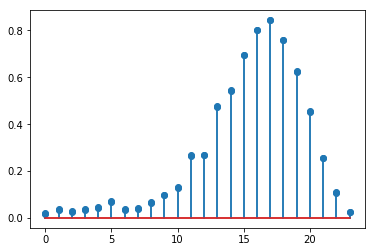

In [14]:
# <SOL>
sML24 = K24 / z24
sMSE24 = (K24+1) / (z24+1)

plt.stem(sML24)
plt.stem(sMSE24)
plt.show()
# </SOL>

* [3.4] One may wonder if spliting the data in segments provides a better model for the time between calls. The joint data likelihood is a useful way to get a first quantitative evaluation of the new model.

    Compute the maximum log-likelihood for the joint model, and save it in variable `L24max`. Compare the result with the value of `Lmax` computed in [2.2].
    
    To compute the maximum log-likelihood of the joint model, take into account that the observations are independent, so that `L24max` is the sum of the values of the maximum log-likelihood compute for every hour.


In [15]:
Lmax24 = np.sum([Lp(sML24[h], z24[h], K24[h]) for h in range(24)])

print('Maximum log-likelihood of the simple model: {}'.format(Lmax))
print('Maximum log-likelihood of the hour-dependent model: {}'.format(Lmax24))

Maximum log-likelihood of the simple model: -4535.110866517586
Maximum log-likelihood of the hour-dependent model: -3520.3133356229164


 * [3.5] Plot the posterior probabilities for each hour slot

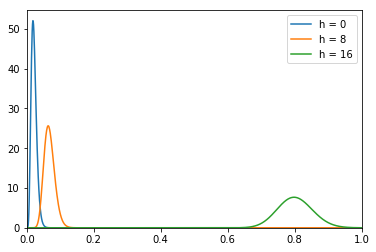

In [17]:
# <SOL>
s = np.linspace(0.0001, 1.0, 1000)

plt.figure()
for h in [0, 8, 16]:
    plt.plot(s, PP(s, z24[h], K24[h]), label='h = {}'.format(h))

plt.xlim((s[0], s[-1]))
plt.ylim((0, plt.ylim()[1]))
plt.legend()
plt.show()
# </SOL>

 * [3.6] Compute maximum likelihood for the new model, and compare it with the original one.

In [ ]:
# <SOL>
# </SOL>


### 3. An improved data model.

#### 3.1. Resource assignment

*Like2Call* has a staff of operators in charge of attending all incoming calls. Operators are expensive, so the company aims at optimizing the human resources assigned to this service. At the same time, the company wants to avoid loosing calls because of the lack of available operators at some time.

One experienced engineer from the company has reasoned as follows: since we have recorded the time of each call, we can compute the total time required to attend all calls in the dataset:

In [ ]:
st = np.sum(d)
print("Total service time = {} minutes".format(st))
print(len(d))

since the dataset registers a period of 5 days (24 hours per day), which are

In [ ]:
sp = n_days*24*60
print("Total service period = {} minutes".format(sp))

we can estimate that, on average, the number of busy operators is about

In [ ]:
print("Average number of busy operators: {}".format(st/sp))

Thus, we can conservatively assign a number of active operators equal to twice the average number of busy operators, to make sure that there will be no lost calls.

In [ ]:
print("Tentative number of active operators at each time: {}".format(2*st/sp))

A young engineering arising from Universidad Carlos III noted that there was something wrong in the reasoning of the experienced engineer. He made some calculations to come up with a better way to assign the human resourcers.

 * [3.1] Plot the exact number of active calls as a function of time. (Think how to do it using `t` and `d`).

In [ ]:
# <SOL>

# Lists of start and end events
e_start = [(x, 1) for x in t]
e_end = [(x, -1) for x in t + d]
e_all = e_start + e_end
e_allsorted = sorted(e_all, key=lambda x: x[0])
t_all = np.array([x[0] for x in e_allsorted])
y = np.array([x[1] for x in e_allsorted])

plt.plot(t_all, np.cumsum(y))
plt.plot([0, t_all[-1]], [10, 10], ':')
plt.show()
# </SOL>


* [3.2] Estimate the total number of calls that would be lost if only 10 operators were active at each time


#### 3.3. Resource allocation.

 * [3.7] Assign a different number of operators to each period, ensuring that the total man-power required to maintain the service (and thus the cost) does not increase, but trying to minimize the number of lost calls.

In [ ]:
# <SOL>
# </SOL>
